In [1]:
import pandas as pd
import numpy as np
from tsa.preprocessing import get_sample_info, tpm_normalization
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.tsa import best_alignment_graph
from tsa.utils import list2floats, inference_timeseries
from tsa.plotting import plot_alignments
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from qnorm import quantile_normalize
import warnings
import sklearn
import random
from sklearn.cluster import k_means, KMeans
from sklearn.decomposition import PCA

### Pinned variables
- normalization: 5 TPM minimum, quantile normalization & log transformation
- template GPR with 10 points/timepoint
- distance metric: correlation

In [59]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

In [4]:
def tpm_normalization(
        tpms: pd.DataFrame,
        column_order: list,
#         genes: list = None
        minimum_value: int = None,
        target: list = None,
) -> pd.DataFrame:
    # filter samples
    bc = tpms[column_order]                             # filter & order samples
    
    # filter genes
    if minimum_value:
        b4 = bc.shape[0]
        bc = bc[bc.max(axis=1) >= minimum_value]        # filter genes by minimum
        aft = b4 - bc.shape[0]
        print(f"Genes with TPM below {minimum_value}: {aft} of {b4} ({round(100*aft/b4,0)}%)")
    bc = bc[bc.median(axis=1) > 0]                      # filter genes by median
    
    # normalize & transform
    if target:
        if len(bc) < len(target):
            # subsample distribution to number of genes
            target = random.sample(target, len(bc))
        elif len(bc) > len(target):
            raise NotImplementedError("query has more genes than target distribution...")
    bc = quantile_normalize(bc, axis=1, target=target)  # normalize
    bc = np.log2(bc+1)                                  # transform
    return bc

def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
    template = template_tpms.to_numpy(dtype=np.float64)
    query = query_tpms.to_numpy(dtype=np.float64)
    cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
    return cost_matrix

def subset_df(df, rows=None, columns=None, sort=True):
    """
    (efficiently) reconstruct a dataframe by row and/or column (name or number)
    
    rows: list of row/index names or numbers
    columns: list of column names or numbers
    """
    if rows:
        if set(rows).issubset(set(df.index)):
            # rows contains dataframe row names
            df = df[df.index.isin(rows)]
        else:
            # rows contains dataframe row numbers
            df = df.iloc[rows]
    if columns:
        if set(columns).issubset(set(df.columns)):
            # columns contains dataframe column names
            df = df[columns]
        else:
            # columns contains dataframe column numbers
            df = df[[df.columns[i] for i in columns]]
    if sort:
        df.sort_index(inplace=True)
    return df

def plot_alignment(cost_matrix, best_path, std_path=None):
    q = cost_matrix.index.to_list()
    extended_template_time = list2floats(cost_matrix.columns)
    t = [extended_template_time[i] for i in best_path]

    plt.rcParams['figure.figsize'] = [8, 6]
    
    plt.plot(q, t, alpha=0.5)
    plt.scatter(q, t, s=10, color="black")
    if std_path is not None:
        plt.errorbar(q, t, color="grey", yerr=std_path2, alpha=0.2, fmt='none')
    
    # add diagonal
    start = min(t[0], q[0])
    end = max(t[-1], q[-1])
    plt.plot([start, end], [start, end], alpha=0.2, ls='--')
    
    plt.title("local alignment")
    plt.ylabel("template (mpf)")
    plt.ylim(t[0], t[-1])
    plt.xlabel("query (mpf)")
    plt.xlim(q[0], q[-1])
    plt.show()
    
def plot_gene(gene, query_tpms, template_tpms_inf, path, scale=False):
    # mapping
    query_time = list2floats(query_tpms.columns)
    extended_template_time = list2floats(template_tpms_inf.columns)
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in path],
    })

    # plot alignment
    x1 = extended_template_time
    x2 = mapped.original_time.to_list()
    y1 = template_tpms_inf.loc[showcase_gene].to_list()
    y2 = query_tpms.loc[showcase_gene].to_list() 
    if scale:
        y1 = sklearn.preprocessing.scale(y1)
        y2 = sklearn.preprocessing.scale(y2)
        
    plt.scatter(x=x1, y=y1)
    plt.scatter(x=x2, y=y2)
    for n in range(len(x2)):
        m = path[n]
        plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

    # pretty stuff
    plt.title(f"{showcase_gene} alignment", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("time (mpf)", fontsize=15)
    start = x1[path[0]]
    end = max(x1[path[-1]], x2[-1])
    a_bit = (end - start) * 0.05
    plt.xlim(start - a_bit, end + a_bit)
    plt.show()

### GPR of all template genes

In [5]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, minimum_value=5)

timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

print(template_tpms.shape)
template_tpms.head(3)

Genes with TPM below 5: 11063 of 32212 (34.0%)
(18906, 90)


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


R^2: 0.9331756320857346
delta: 2.898678021606953


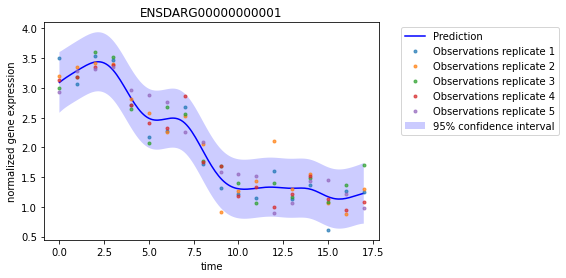

R^2: 0.947701758447525
delta: 6.160785087957404


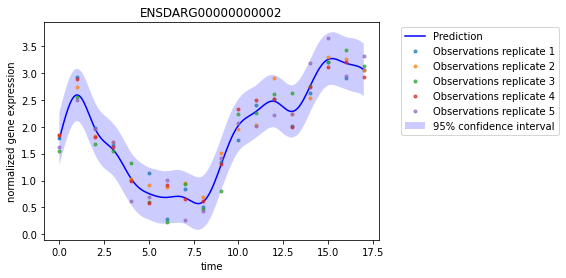

R^2: 0.9750462940012116
delta: 7.742962066164261


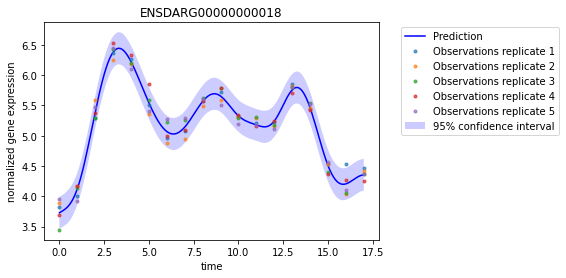

In [6]:
# run 3x with pictures
template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=True, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)

### optional: filter template genes by r2, variability or both

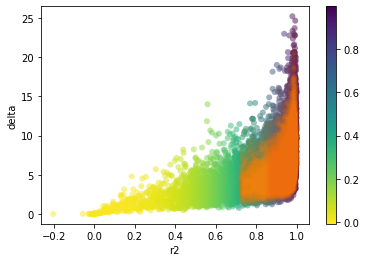

In [7]:
# remove genes that cannot weren't modelled accurately
n = 17_000
gpr_normscores = score_normalization(gpr_scores, weight_expr=0, weight_r2=3)
plot_scores(gpr_normscores, highlight_top_n=n)

top_template_genes = best_n_genes(gpr_normscores, n)

### filter for overlapping (expressed) genes

In [60]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, minimum_value=5, target=target_distribution)
samples2time = {}
for k, v_list in time2samples.items():
    for v in v_list:
        if v not in samples2time:
            samples2time[v] = k           
query_tpms = query_tpms.rename(columns=samples2time)

print(query_tpms.shape)
query_tpms.head(3)

Genes with TPM below 5: 14459 of 32212 (45.0%)
(7224, 106)


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.369056,1.306089,2.101460,2.225933,2.364768,2.145632,1.996084,1.493502,2.164611,2.337159,...,1.863499,2.118177,1.776728,2.648993,2.015170,1.953897,1.957138,1.556783,2.353763,1.828137
ENSDARG00000000019,2.394074,1.306089,1.871792,1.973370,2.411703,1.546110,2.563048,2.534919,1.394825,2.191212,...,2.061187,1.367843,0.799732,1.587596,1.632503,1.394845,0.799732,1.707531,2.117843,1.828137
ENSDARG00000000068,2.402719,1.306089,2.529714,0.890716,2.433139,2.421693,2.156303,1.493502,1.394825,1.294708,...,1.285417,0.799732,0.799732,1.587596,0.799732,1.880557,0.799732,1.979529,1.134824,1.828137


In [61]:
# intersection of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

6841 overlapping genes


### Bootstrapping: Goodness of Fit

In [62]:
training_df = template_tpms_inf[template_tpms_inf.index.isin(starting_genes)]

# select number of clusters based on the number of genes
n_clusters = max(10, int(len(starting_genes)/300))

# K-means clustering on TPMs
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(training_df)
k = kmeans.predict(training_df)

template_gene_clusters = pd.DataFrame({"gene": training_df.index, "cluster": k})

average TSA of 10 alignments with 20% of genes per cluster 
(22 clusters, 1367 total genes)


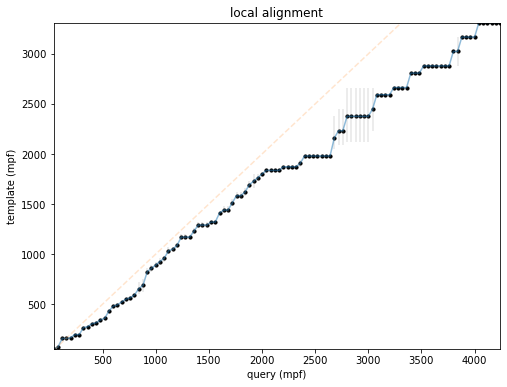

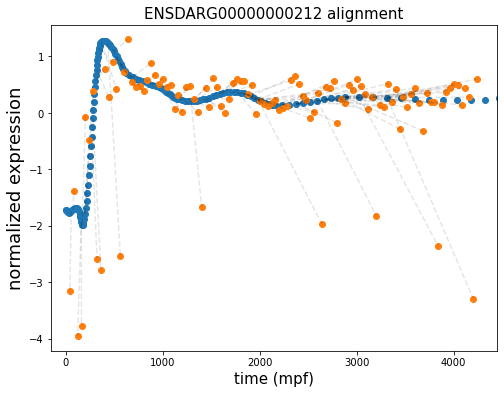

In [63]:
tsa_fraction = 0.2  # use this % of genes per cluster for TSA
tries = 10

# TSA on subset per cluster
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%", end="\r")
    
    # get a fraction of genes per cluster
    genes = template_gene_clusters.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
    cost_matrix = get_cost_matrix(t, q, metric='correlation')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]

# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
print(f"average TSA of {tries} alignments with {int(tsa_fraction*100)}% of genes per cluster \n"
      f"({len(set(template_gene_clusters.cluster))} clusters, {len(q)} total genes)")
plot_alignment(c, avg_path, std_path2)

showcase_gene = "ENSDARG00000000212"
plot_gene(showcase_gene, query_tpms, template_tpms_inf, avg_path, scale=True)

In [83]:
# get 2 dataframe with desired genes and aligned timepoints
template_Y = subset_df(template_tpms_inf, starting_genes, avg_path)
query_Y = subset_df(query_tpms, starting_genes)

# scale y-axis per gene
template_Y = pd.DataFrame(
    sklearn.preprocessing.scale(template_Y, axis=1),  # sklearn.preprocessing.minmax_scale(
    index=template_Y.index, 
    columns=template_Y.columns
)
query_Y = pd.DataFrame(
    sklearn.preprocessing.scale(query_Y, axis=1),
    index=query_Y.index, 
    columns=query_Y.columns
)

# R^2: how close are the two time series? (argument order is arbitrary)
scores = sklearn.metrics.r2_score(query_Y.T, template_Y.T, multioutput='raw_values')
scores = pd.DataFrame({"gene": query_Y.index, "score": scores})

print(scores[scores.gene==showcase_gene])

                 gene     score
8  ENSDARG00000000212  0.034806


In [98]:
# subset per cluster by fit
fraction = 0.2

# combine score and cluster info per gene
subset = scores.copy()
subset = subset.merge(template_gene_clusters, on="gene", how="right")
print("All genes per cluster")
print("mean fit score:", round(subset.score.mean(), 3))
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print(pd.concat([s, g], axis=1))

print()

# take the top fraction of each cluster
subset.sort_values("score", ascending=False, inplace=True)
subset = subset.groupby("cluster").apply(lambda x: x.head(int(len(x)*fraction))).reset_index(drop=True)  # top fraction/cluster
print("Top genes per cluster")
print("mean fit score:", round(subset.score.mean(), 3))
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print(pd.concat([s, g], axis=1))
subset = subset.gene.to_list()

All genes per cluster
mean fit score: -0.32
            score  n_genes
cluster                   
0       -0.220988      412
1       -0.557839      446
2       -0.225741       96
3       -0.031926      198
4        0.140998      235
5       -0.207772      358
6       -0.147684      180
7       -0.513139      437
8       -0.443754      436
9       -0.446337      535
10      -0.375603      302
11      -0.383970      279
12      -0.536475      313
13      -0.400021      576
14       0.496613       80
15      -0.506021      533
16      -0.267725      227
17       0.327754      252
18      -0.375117      222
19      -0.502603      459
20       0.144098      178
21       0.193474       87

Top genes per cluster
mean fit score: -0.033
            score  n_genes
cluster                   
0        0.014463      206
1       -0.261894      223
2        0.103616       48
3        0.263695       99
4        0.453287      117
5        0.043927      179
6        0.208830       90
7       -0.174979  

average TSA of 10 alignments with 20% of genes per cluster 
(22 clusters, 685 total genes)


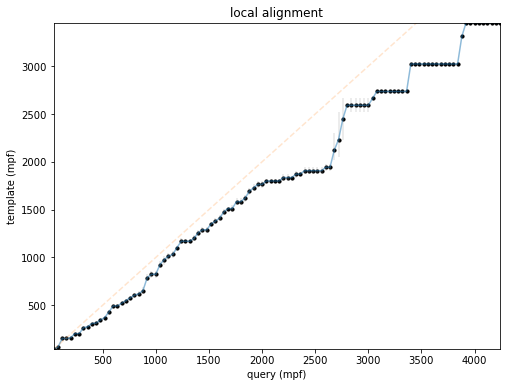

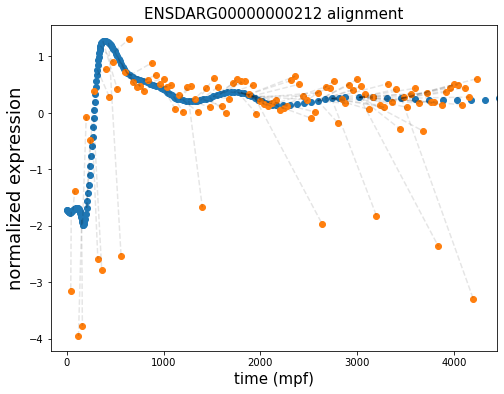

In [99]:
tsa_fraction = 0.2  # use this % of genes per cluster for TSA
tries = 10

subset_template = template_gene_clusters[template_gene_clusters.gene.isin(subset)]

# TSA on subset per cluster
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%", end="\r")
    
    # get a fraction of genes per cluster
    genes = subset_template.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
    cost_matrix = get_cost_matrix(t, q, metric='correlation')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]

# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
print(f"average TSA of {tries} alignments with {int(tsa_fraction*100)}% of genes per cluster \n"
      f"({len(set(template_gene_clusters.cluster))} clusters, {len(q)} total genes)")
plot_alignment(c, avg_path, std_path2)

showcase_gene = "ENSDARG00000000212"
plot_gene(showcase_gene, query_tpms, template_tpms_inf, avg_path, scale=True)